# Skin Cancer Lesion Classification using HAM10000 dataset

Dataset link: \
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

Data description: \
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

The 7 classes of skin cancer lesions included in this dataset are:
- Melanocytic nevi (nv)
- Melanoma (mel)
- Benign keratosis-like lesions (bkl)
- Basal cell carcinoma (bcc) 
- Actinic keratoses (akiec)
- Vascular lesions (vas)
- Dermatofibroma (df)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [4]:
skin_df = pd.read_csv('Datasets/HAM10000/HAM10000_metadata.csv')
SIZE = 32

### Pre-Processing

In [5]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [6]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

### EDA

C:\Work\Anaconda\envs\mllib\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


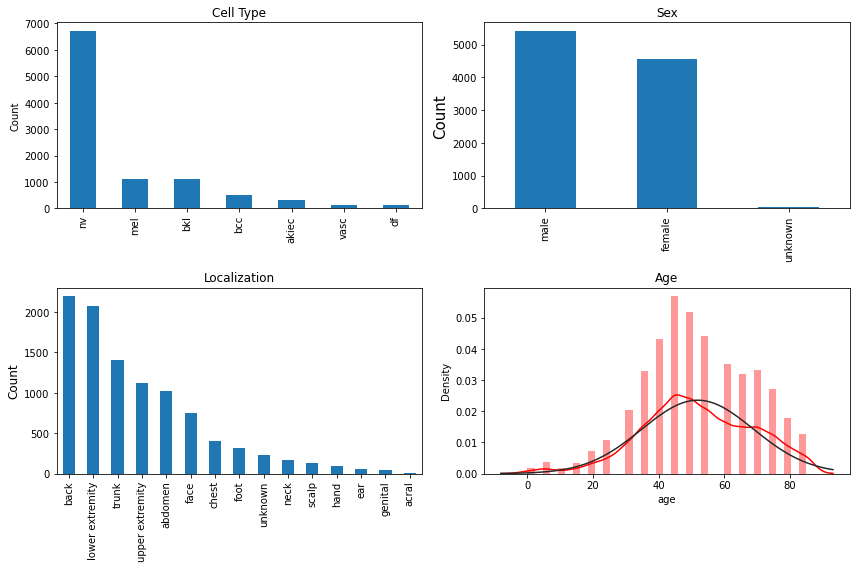

In [7]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [8]:
# Distribution of data into various classes 
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


### Balancing Dataset using Resampling

In [9]:
from sklearn.utils import resample
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [10]:
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [11]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [12]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

5    500
3    500
1    500
6    500
4    500
2    500
0    500
Name: label, dtype: int64


In [14]:
skin_df_balanced.to_csv('data/balanced_meta_data.csv')

### Read Image files

In [15]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('Datasets/HAM10000/', '*', '*.jpg'))}

In [16]:
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

In [17]:
#Use the path to read images into numpy array
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [18]:
skin_df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,Datasets/HAM10000\HAM10000_images_part_1\ISIC_...,"[[[155, 118, 107], [162, 126, 118], [174, 140,..."
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,Datasets/HAM10000\HAM10000_images_part_1\ISIC_...,"[[[138, 76, 82], [131, 64, 68], [139, 73, 81],..."
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,Datasets/HAM10000\HAM10000_images_part_1\ISIC_...,"[[[123, 86, 87], [174, 137, 137], [197, 161, 1..."
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,Datasets/HAM10000\HAM10000_images_part_1\ISIC_...,"[[[205, 149, 175], [207, 149, 169], [214, 158,..."
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,Datasets/HAM10000\HAM10000_images_part_1\ISIC_...,"[[[203, 174, 199], [205, 174, 197], [206, 175,..."


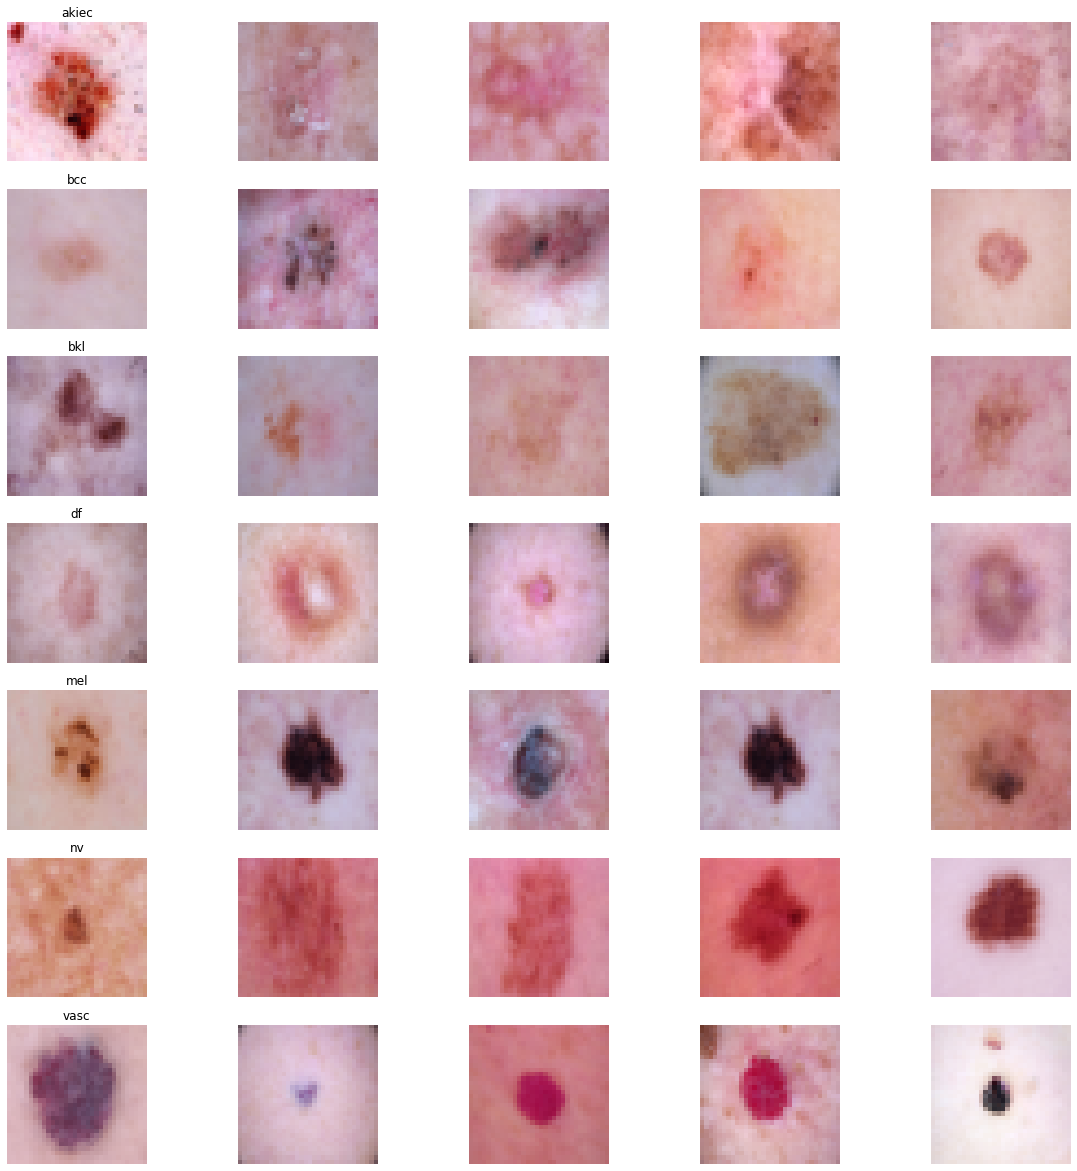

In [19]:
n_samples = 5  # number of samples for plotting

# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


In [20]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())

In [21]:
# Scale values to 0-1. You can also used standardscaler or other scaling methods.
X = X/255.  
#Assign label values to Y
Y=skin_df_balanced['label']  

In [22]:
# Convert labels to categorical as this is a multiclass classification problem
Y_cat = to_categorical(Y, num_classes=7) 

In [23]:
# Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

### Model

In [52]:
model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 128)       295040    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)         

In [53]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

### Training

In [54]:
batch_size = 16 
epochs = 100

history = model.fit(
                    x_train, y_train,
                    epochs=epochs,
                    batch_size = batch_size,
                    validation_data=(x_test, y_test),
                    verbose=1)

Train on 2625 samples, validate on 875 samples
Epoch 1/100
2625/2625 [==============================] - 8s 3ms/step - loss: 1.8908 - acc: 0.1924 - val_loss: 1.7995 - val_acc: 0.2606
Epoch 2/100
2625/2625 [==============================] - 8s 3ms/step - loss: 1.7161 - acc: 0.2846 - val_loss: 1.5975 - val_acc: 0.3246
Epoch 3/100
2625/2625 [==============================] - 8s 3ms/step - loss: 1.5626 - acc: 0.3493 - val_loss: 1.4889 - val_acc: 0.3794
Epoch 4/100
2625/2625 [==============================] - 8s 3ms/step - loss: 1.4436 - acc: 0.4145 - val_loss: 1.4260 - val_acc: 0.4217
Epoch 5/100
2625/2625 [==============================] - 8s 3ms/step - loss: 1.3789 - acc: 0.4480 - val_loss: 1.3474 - val_acc: 0.4286
Epoch 6/100
2625/2625 [==============================] - 8s 3ms/step - loss: 1.3027 - acc: 0.4811 - val_loss: 1.3212 - val_acc: 0.4594
Epoch 7/100
2625/2625 [==============================] - 8s 3ms/step - loss: 1.2875 - acc: 0.4960 - val_loss: 1.2485 - val_acc: 0.5223
Epoch 8/

Epoch 61/100
2625/2625 [==============================] - 8s 3ms/step - loss: 0.5607 - acc: 0.7851 - val_loss: 0.7857 - val_acc: 0.7646
Epoch 62/100
2625/2625 [==============================] - 8s 3ms/step - loss: 0.6047 - acc: 0.7825 - val_loss: 0.7971 - val_acc: 0.7360
Epoch 63/100
2625/2625 [==============================] - 8s 3ms/step - loss: 0.5611 - acc: 0.7890 - val_loss: 0.7934 - val_acc: 0.7600
Epoch 64/100
2625/2625 [==============================] - 8s 3ms/step - loss: 0.5793 - acc: 0.7874 - val_loss: 0.7864 - val_acc: 0.7440
Epoch 65/100
2625/2625 [==============================] - 8s 3ms/step - loss: 0.5740 - acc: 0.7832 - val_loss: 0.7913 - val_acc: 0.7520
Epoch 66/100
2625/2625 [==============================] - 8s 3ms/step - loss: 0.5839 - acc: 0.7863 - val_loss: 0.8232 - val_acc: 0.7303
Epoch 67/100
2625/2625 [==============================] - 8s 3ms/step - loss: 0.8725 - acc: 0.6716 - val_loss: 0.8871 - val_acc: 0.6914
Epoch 68/100
2625/2625 [========================

In [55]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

875/875 [==============================] - 0s 516us/step
Test accuracy: 0.7497143149375916


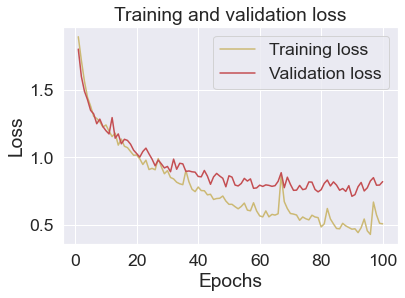

In [56]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

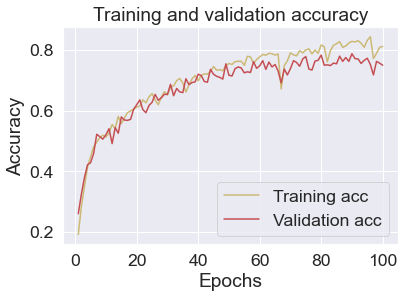

In [57]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Predictions

In [58]:
# Prediction on test data
y_pred = model.predict(x_test)

In [59]:
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 

In [60]:
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

<AxesSubplot:>

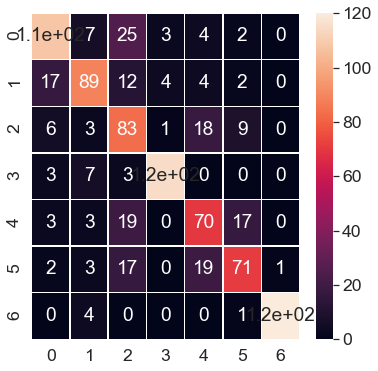

In [61]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

### Misclassifications

Text(0, 0.5, 'Fraction of incorrect predictions')

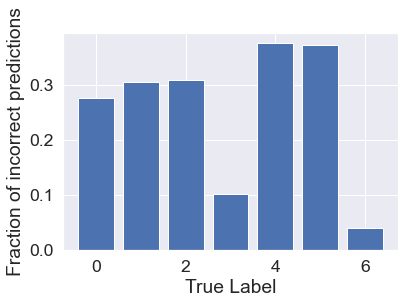

In [62]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')